In [63]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from src.model import CRNN

In [64]:
!where python3

/usr/local/bin/python3
/usr/bin/python3


## load model

In [65]:
model = CRNN(img_channel=32, img_height=128, img_width=128, num_class=5)

In [66]:
model.cnn

Sequential(
  (conv0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inpl

## compute_thres

global pruning

In [62]:
# 剪枝比率
pruning_rate = 0.5

In [107]:
"""計算global threshold"""
# 計算總共多少 channels
total = 0
cfg = [32]
for m in model.cnn.modules():
    if isinstance(m, nn.Conv2d):
        total += m.weight.data.shape[0]
        cfg.append(m.weight.data.shape[0])
        # weight_copy = m.weight.data.abs().clone()
        # weight_copy = weight_copy.cpu().numpy()
        # total += weight_copy

# 所有 weights 值 取絕對值存進 bn
bn = torch.zeros(total) # 1*n維
weight_list = []
index = 0
for k, m in enumerate(model.cnn.modules()):
    if isinstance(m, nn.Conv2d):
        print(k, m.weight.data.shape[0])
        weight_copy = m.weight.data.abs().clone()
        weight_copy = weight_copy.cpu().numpy()

        # num_keep = int(out_channels * (1 - pruning_rate)) # 要留下多少比例 (1 - pruning rate)
        # print('num_keep:', num_keep)
        L1_norm = np.sum(weight_copy, axis=(1, 2, 3)) # 算L1 全部加總
        '''
        [8.548319  8.584734  7.830537  8.143877  9.192205  8.561562  8.281859
        8.481453  8.994378  8.91869   8.544003  8.693865  8.306074  8.96825 ...]
        看這層有幾個channels就有幾個L1加總
        '''
        # if k == 16:
        #     print(m.weight.data.shape[0])
        #     print(L1_norm)
        #     break
        weight_list += list(L1_norm)
sort_list = sorted(weight_list)
thre_index = int(total * pruning_rate) # scale sparse rate 0.5 剪枝比例
thre = sort_list[thre_index] if thre_index != 0 else 0 # 取第 thre_index 個值當作 threshold，如果 thre_index=0 代表全留，不能取第 0 個要直接改 0

# 之後 weight 會跟 thre 這個數字比大小，產生一個 0, 1 的 tensor，大於 thre 的留下(小於 thre 的就不會被存進 newmodel)
print('Global threshold: {}'.format(thre))
print('Total channels: {}'.format(total))

1 64
5 128
9 256
12 256
16 512
19 512
23 512
Global threshold: 23.763320922851562
Total channels: 2240


In [96]:
"""記錄誰該留下誰該剪掉"""
pruned = 0
cfg_new = [32] # remaining channel
cfg_mask = [torch.ones(32)] # 記錄每層 channels，以 0,1 表示剪枝，假設 channels=3, cfg_mask=[0,1,1]
for k, m in enumerate(model.cnn.modules()):
    if isinstance(m, nn.Conv2d):
        thre_ = 0 if k in pruning_cfg['cnn']['skip'] else thre # skip 的 layer thre=0
        weight_copy = m.weight.data.abs().clone()
        weight_copy = weight_copy.cpu().numpy()
        L1_norm = np.sum(weight_copy, axis=(1, 2, 3)) # 算L1 全部加總
        L1_tensor = torch.from_numpy(L1_norm)
        # print(thre)
        # print(L1_tensor)
        mask = L1_tensor.gt(thre_).float() # 比大小，大的標記 1 & 小的標記 0，存進 mask
        # print(mask)
        # if k ==2:
        #     break
        cfg_new.append(int(torch.sum(mask)))
        cfg_mask.append(mask.clone())

        pruned = pruned + mask.shape[0] - torch.sum(mask) # 計算pruning ratio
        print('layer index: {:d} \t total channel: {:d} \t remaining channel: {:d}'.
            format(k, mask.shape[0], int(torch.sum(mask))))
pruned_ratio = pruned / total
print('-------------------------------------------------------------------------')
print('channels pruned / channels total: {} / {}'.format(pruned, total))
print('pruned ratio: {}'.format(pruned_ratio))

layer index: 1 	 total channel: 64 	 remaining channel: 0
layer index: 5 	 total channel: 128 	 remaining channel: 0
layer index: 9 	 total channel: 256 	 remaining channel: 0
layer index: 12 	 total channel: 256 	 remaining channel: 202
layer index: 16 	 total channel: 512 	 remaining channel: 405
layer index: 19 	 total channel: 512 	 remaining channel: 512
layer index: 23 	 total channel: 512 	 remaining channel: 0
-------------------------------------------------------------------------
channels pruned / channels total: 1121.0 / 2240
pruned ratio: 0.5004464387893677


In [108]:
print(cfg)
print(cfg_new)

[32, 64, 128, 256, 256, 512, 512, 512]
[32, 0, 0, 0, 202, 405, 512, 0]


# Graph 1: Absolute sum of filter weights for each layer

In [114]:
import matplotlib.pyplot as plt

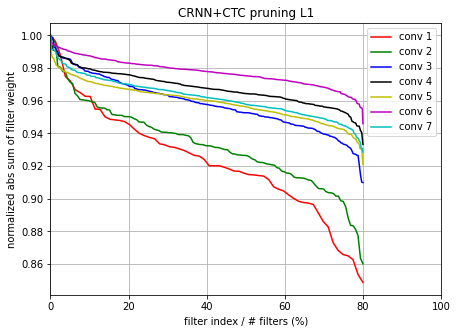

In [118]:
colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
lines = ['-', '--', '-.']

plt.figure(figsize=(7,5))
conv_count = 0
for layer in model.cnn: # 放入自己的 model
    if isinstance(layer, nn.Conv2d):
        line_style = colors[conv_count%len(colors)] + lines[conv_count//len(colors)]
        
        # 取出各層的 filter 
        fw = layer.weight.data.cpu().numpy()
        
        # 取絕對值 + 排序 (大到小)
        sorted_abs_sum = np.sort(np.sum(np.abs(fw.reshape(fw.shape[0], -1)), axis=1))[::-1]
        
        # 將權重標準化 0~1 之間
        normalized_abs_sum = sorted_abs_sum/sorted_abs_sum[0]
        conv_count += 1
        plt.plot(np.linspace(0, 100, normalized_abs_sum.shape[0]), normalized_abs_sum, line_style, label='conv %d'%conv_count)
        
plt.title("CRNN+CTC pruning L1")        
plt.ylabel("normalized abs sum of filter weight")
plt.xlabel("filter index / # filters (%)")
plt.legend(loc='upper right')
plt.xlim([0, 140])
plt.grid()
plt.savefig("figure1.png", dpi=150, bbox_inches='tight')
plt.show()

## set param

In [109]:
# cfg
'''
model: 各架構位置
skip: 不剪枝的層數
cfg: 剪枝後剩餘的 channel 數量
cfg_mask: 剪枝後剩餘 channel 的位置
cat_layer: 有 concat 的層數
'''
pruning_cfg = {
    'cnn':{
        'model': model.cnn,
        'skip': [],
        'cfg': [],
        'cfg_mask': [],
        'cat_layer': []
    }
}

In [15]:
cfg = [64, 128, 256, 256, 512, 512, 512]

In [39]:
cfg_mask = []
cfg_new = [32]
# layer_id = 0
for m in model.modules():
    if isinstance(m, nn.Conv2d):
        out_channels = m.weight.data.shape[0]

        weight_copy = m.weight.data.abs().clone()
        weight_copy = weight_copy.cpu().numpy()
        num_keep = int(out_channels * (1 - pruning_rate)) # 要留下多少比例 (1 - pruning rate)
        # print('num_keep:', num_keep)
        L1_norm = np.sum(weight_copy, axis=(1, 2, 3)) # 算L1 全部加總
        arg_max = np.argsort(L1_norm)
        # x中的元素從小到大排列，提取其對應的index(索引)，然後輸出到y
        # x=np.array([1,4,3,-1,6,9])
        # y=array([3,0,2,1,4,5])

        # arg_max_rev = arg_max[::-1][:cfg[layer_id]]
        #[::-1]小排到大，[:num_keep]取要留下的
        arg_max_rev = arg_max[::-1][:num_keep] # 留下哪幾個filters
        # print('arg_max_rev:', len(arg_max_rev))
        # print(arg_max_rev)

        # assert arg_max_rev.size == cfg[layer_id], "size of arg_max_rev not correct"
        mask = torch.zeros(out_channels) # 一個空的 裡面都存0的matrix， 1*out_channels維
        mask[arg_max_rev.tolist()] = 1 # 把要留下的人給1
        cfg_mask.append(mask) # [tensor(一堆0, 1), tensor(一堆0, 1)]
        cfg_new.append(num_keep)
        print(f'original channels:{out_channels}, num_keep:{num_keep}')
        # print(cfg_mask)
        
        # layer_id += 1
    # elif isinstance(m, nn.MaxPool2d):
    #     layer_id += 1

original channels:64, num_keep:32
original channels:128, num_keep:64
original channels:256, num_keep:128
original channels:256, num_keep:128
original channels:512, num_keep:256
original channels:512, num_keep:256
original channels:512, num_keep:256


## save weights to new model

In [112]:
# cfg
'''
model: 各架構位置
skip: 不剪枝的層數
cfg: 剪枝後剩餘的 channel 數量
cfg_mask: 剪枝後剩餘 channel 的位置
cat_layer: 有 concat 的層數
'''
pruning_cfg = {
    'cnn':{
        'model': model.cnn,
        'skip': [],
        'cfg': cfg_new,
        'cfg_mask': cfg_mask,
        'cat_layer': []
    }
}
print(pruning_cfg['cnn']['cfg'])

[32, 0, 0, 0, 202, 405, 512, 0]


In [ ]:
# 用新的 cfg 定義新模型架構
newmodel = CRNN(img_channel=1, img_height=32, img_width=100, num_class=42, pruning_cfg=pruning_cfg['cnn']['cfg'])

In [60]:
start_mask = torch.ones(32)
layer_id_in_cfg = 0
end_mask = cfg_mask[layer_id_in_cfg]
for [m0, m1] in zip(model.modules(), newmodel.modules()):
    if isinstance(m0, nn.BatchNorm2d):
        print('batch:', layer_id_in_cfg)
        print('======================')
        idx1 = np.squeeze(np.argwhere(np.asarray(end_mask.cpu().numpy())))
        if idx1.size == 1:
            idx1 = np.resize(idx1,(1,))
        m1.weight.data = m0.weight.data[idx1.tolist()].clone()
        m1.bias.data = m0.bias.data[idx1.tolist()].clone()
        m1.running_mean = m0.running_mean[idx1.tolist()].clone()
        m1.running_var = m0.running_var[idx1.tolist()].clone()
        layer_id_in_cfg += 1
        start_mask = end_mask
        if layer_id_in_cfg < len(cfg_mask):  # do not change in Final FC
            end_mask = cfg_mask[layer_id_in_cfg]
    elif isinstance(m0, nn.Conv2d):
        print('conv:', layer_id_in_cfg)
        idx0 = np.squeeze(np.argwhere(np.asarray(start_mask.cpu().numpy())))
        idx1 = np.squeeze(np.argwhere(np.asarray(end_mask.cpu().numpy())))
        print('In shape: {:d}, Out shape {:d}.'.format(idx0.size, idx1.size))
        if idx0.size == 1:
            idx0 = np.resize(idx0, (1,))
        if idx1.size == 1:
            idx1 = np.resize(idx1, (1,))
        w1 = m0.weight.data[:, idx0.tolist(), :, :].clone()
        w1 = w1[idx1.tolist(), :, :, :].clone()
        m1.weight.data = w1.clone()
        # print(m1.weight.data.shape)
        # break
    elif isinstance(m0, nn.Linear):
        if layer_id_in_cfg == len(cfg_mask):
            print('Linear:', layer_id_in_cfg)
            idx0 = np.squeeze(np.argwhere(np.asarray(cfg_mask[-1].cpu().numpy())))
            if idx0.size == 1:
                idx0 = np.resize(idx0, (1,))
            m1.weight.data = m0.weight.data[:, idx0].clone()
            m1.bias.data = m0.bias.data.clone()
            layer_id_in_cfg += 1
            continue
        m1.weight.data = m0.weight.data.clone()
        m1.bias.data = m0.bias.data.clone()

conv: 0
In shape: 32, Out shape 32.
batch: 0
conv: 1
In shape: 32, Out shape 64.
batch: 1
conv: 2
In shape: 64, Out shape 128.
batch: 2
conv: 3
In shape: 128, Out shape 128.
batch: 3
conv: 4
In shape: 128, Out shape 256.
batch: 4
conv: 5
In shape: 256, Out shape 256.
batch: 5
conv: 6
In shape: 256, Out shape 256.
batch: 6
Linear: 7


In [57]:
# 新的 model
# torch.size() 順序是 output channel,  input channel, kernel size
for i in newmodel.cnn.state_dict():
    if ('conv' in i) and ('weight' in i):
        print(("================= {} =================").format(i.split('.')[0]))
        print('Conv shape: {}'.format(newmodel.cnn.state_dict()[i].shape))
    if ('batchnorm' in i) and ('weight' in i):
        print('Batch shape: {}'.format(newmodel.cnn.state_dict()[i].shape))

================= conv0 =================
Conv shape: torch.Size([32, 32, 3, 3])
Batch shape: torch.Size([32])
================= conv1 =================
Conv shape: torch.Size([64, 32, 3, 3])
Batch shape: torch.Size([64])
================= conv2 =================
Conv shape: torch.Size([128, 64, 3, 3])
Batch shape: torch.Size([128])
================= conv3 =================
Conv shape: torch.Size([128, 128, 3, 3])
Batch shape: torch.Size([128])
================= conv4 =================
Conv shape: torch.Size([256, 128, 3, 3])
Batch shape: torch.Size([256])
================= conv5 =================
Conv shape: torch.Size([256, 256, 3, 3])
Batch shape: torch.Size([256])
================= conv6 =================
Conv shape: torch.Size([256, 256, 2, 2])
Batch shape: torch.Size([256])


In [61]:
newmodel.cnn

Sequential(
  (conv0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace